In [3]:
import pandas as pd
from pathlib import Path

# Define input directories
bracken_dir1 = Path("/home/jpereira/Results/kraken_snake/MG1/Data/bracken/")
bracken_dir2 = Path("/home/jpereira/Results/kraken_snake/MG2/Data/bracken/")

bracken_dir1 = Path("/home/jpereira/Results/kraken_snake/MG1_subsample/Data/bracken/")
bracken_dir2 = Path("/home/jpereira/Results/kraken_snake/MG2_subsample/Data/bracken/")
output_dir = Path("/home/jpereira/Results/kraken_snake/MG1_MG2/ClustDiv")
output_dir.mkdir(parents=True, exist_ok=True)

# Collect all .bracken files
bracken_files = list(bracken_dir1.glob("*/*.bracken.*")) + list(bracken_dir2.glob("*/*.bracken.*"))

# Initialize the abundance DataFrame
abundance_df = pd.DataFrame()

# Process each Bracken file
for file in bracken_files:
    df = pd.read_csv(file, sep="\t", usecols=["name", "new_est_reads"])
    sample_name = file.stem  # Just the file name without extension
    df = df.set_index("name").rename(columns={"new_est_reads": sample_name})
    abundance_df = abundance_df.join(df, how="outer") if not abundance_df.empty else df

# Finalize the abundance table
abundance_df = abundance_df.fillna(0).T  # Transpose: samples as rows

# Optional: Save to file
# abundance_df.to_csv("bracken_combined_abundance.tsv", sep="\t")

# View the result
abundance_df.index = abundance_df.index.str.replace(pat="\.bracken\..*", repl="", regex=True)


abundance_tsv = output_dir / "bracken_combined_abundance.tsv"
abundance_df.to_csv(abundance_tsv, sep='\t', index=True)

<>:33: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_1514717/1315216244.py:33: SyntaxWarning: invalid escape sequence '\.'
  abundance_df.index = abundance_df.index.str.replace(pat="\.bracken\..*", repl="", regex=True)


In [4]:
import pandas as pd
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
import seaborn as sns
import matplotlib.pyplot as plt

def make_pca(abundance_df: pd.DataFrame, metadata_df: pd.DataFrame, hue_col: str, interecept_dfs: bool = False, show_plot=False):
    
    if interecept_dfs:
        shared_index = abundance_df.index.intersection(metadata_df.index)
        abundance_df = abundance_df.loc[shared_index]
        metadata_df = metadata_df.loc[shared_index]

    # Compute Bray–Curtis distance matrix
    bc_dm = beta_diversity("braycurtis", abundance_df.values, ids=abundance_df.index)

    # Perform PCoA
    pcoa_results = pcoa(bc_dm)

    from scipy.stats import spearmanr

    # Correlate each taxon's abundance with PC1
    pcoa1_scores = pcoa_results.samples['PC1']
    pcoa2_scores = pcoa_results.samples['PC2']

    # Save coordinates to file
    pcoa_results.samples.to_csv("pcoa_coordinates.tsv", sep="\t")

    # Merge coordinates with metadata
    coords = pcoa_results.samples
    coords_with_meta = coords.join(metadata_df)

    if show_plot:
        # Plot with seaborn
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=coords_with_meta,
            x="PC1",
            y="PC2",
            hue=hue_col,
            palette="Set2",
            s=100,
            edgecolor="black"
        )
        plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
        plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")
        plt.title(f"PCoA colored by {hue_col}")
        plt.grid(True)
        plt.legend(title=hue_col)
        plt.tight_layout()
        plt.show()

    return pcoa1_scores, pcoa2_scores


In [5]:
abundance_tsv = output_dir / "bracken_combined_abundance.tsv"
metadata_csv = Path("/home/jpereira/kraken_snake/metadata/metadata.MG1_MG2.csv")

df = pd.read_csv(abundance_tsv, sep="\t", index_col=0)
m_df = pd.read_csv(metadata_csv, sep='\t', index_col=0)

/home/jpereira/miniconda3/envs/py_bio/lib/python3.13/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.010193984179520417 whereas the largest positive one is 0.5376616979409412.
  warn(
/home/jpereira/miniconda3/envs/py_bio/lib/python3.13/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.015312268326221198 whereas the largest positive one is 1.1580973849119998.
  warn(
/tmp/ipykernel_1509490/3149501567.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

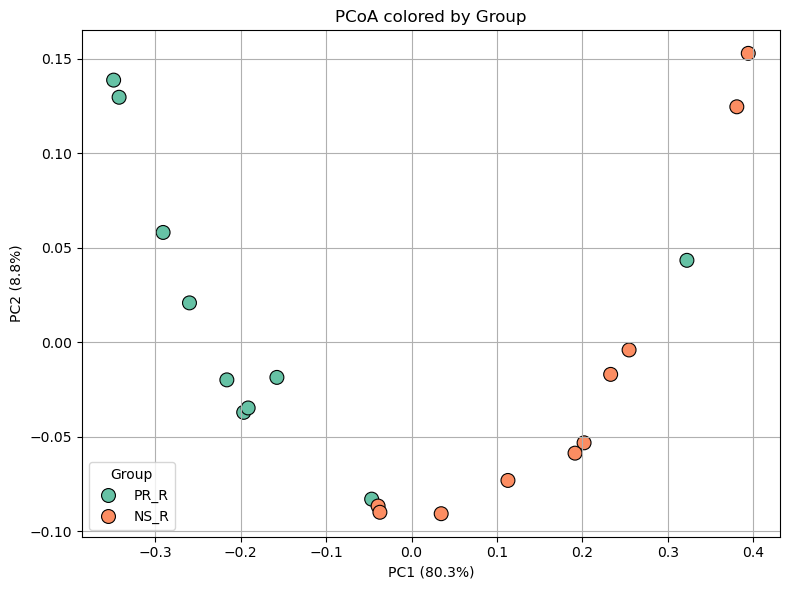

CACZNT01         0.800904
RUG14871         0.802860
RUG612           0.803008
Blautia_A        0.803008
MGYG000292022    0.805420
                   ...   
UMGS1696         0.957895
RUG740           0.959398
HGM13006         0.960902
RUG756           0.963910
SFMI01           0.975940
Length: 77, dtype: float64

In [ ]:
from scipy.stats import spearmanr

# Filter metadata and abundance for the selected groups
selected_groups = ['PR_R', 'NS_R']
filtered_meta = m_df[m_df['Group'].isin(selected_groups)]
filtered_abundance = df.loc[df.index.intersection(filtered_meta.index)]

# Run PCoA without plotting
pcoa1_scores, pcoa2_scores = make_pca(
    abundance_df=filtered_abundance,
    metadata_df=filtered_meta,
    hue_col="Group",
    interecept_dfs=True,
    show_plot=False
)

# Calculate Spearman correlation of each taxon with PC2
taxon_corrs = filtered_abundance.apply(lambda col: spearmanr(col, pcoa2_scores)[0])
taxon_corrs_1 = filtered_abundance.apply(lambda col: spearmanr(col, pcoa1_scores)[0])

# Identify most strongly correlated taxa
drop_taxa = taxon_corrs[taxon_corrs.abs() > 0.8]

# Get abundance data only for those important taxa
important_taxa_df = filtered_abundance[drop_taxa.index]


pc1_scores, pc2_scores = make_pca(abundance_df=important_taxa_df,
    metadata_df=filtered_meta,
    hue_col="Group",
    interecept_dfs=True,
    show_plot=True)

taxon_corrs_1 = filtered_abundance.apply(lambda col: spearmanr(col, pc1_scores)[0])
drop_taxa_1 = taxon_corrs_1[taxon_corrs_1.abs() > 0.8]
#drop_taxa_1.abs().sort_values()

/home/jpereira/miniconda3/envs/cluster-vis-env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.018087525714515246 whereas the largest positive one is 0.6868016973663352.
  warn(
/tmp/ipykernel_702294/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_702294/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

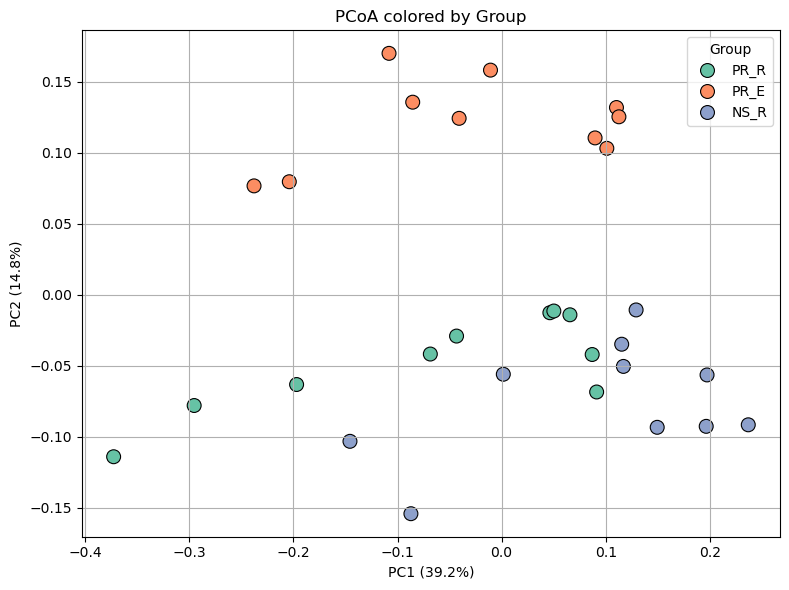

/home/jpereira/miniconda3/envs/cluster-vis-env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.010193984179520417 whereas the largest positive one is 0.5376616979409412.
  warn(
/tmp/ipykernel_702294/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_702294/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

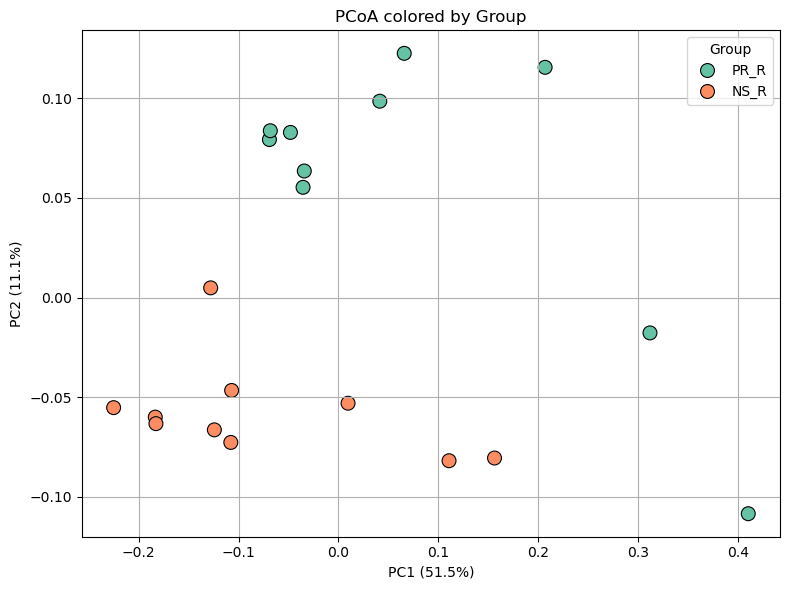

/tmp/ipykernel_702294/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_702294/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


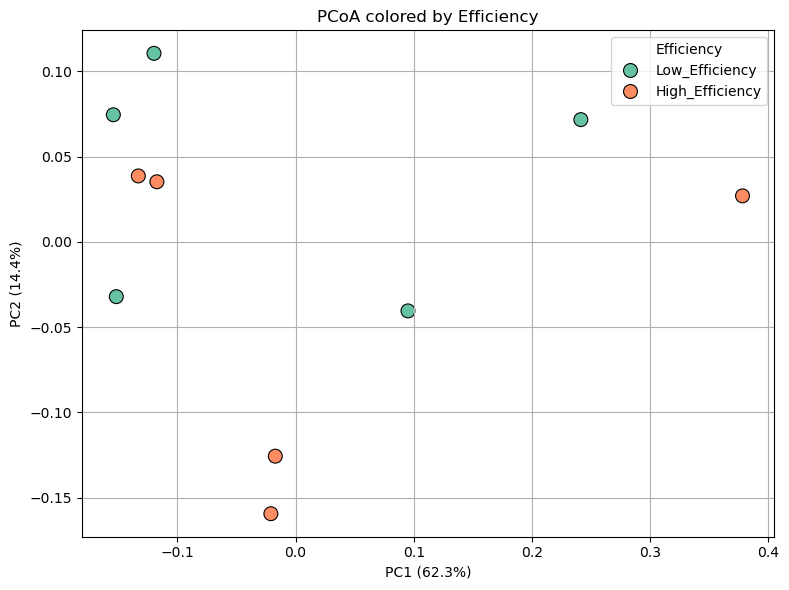

/tmp/ipykernel_702294/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_702294/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


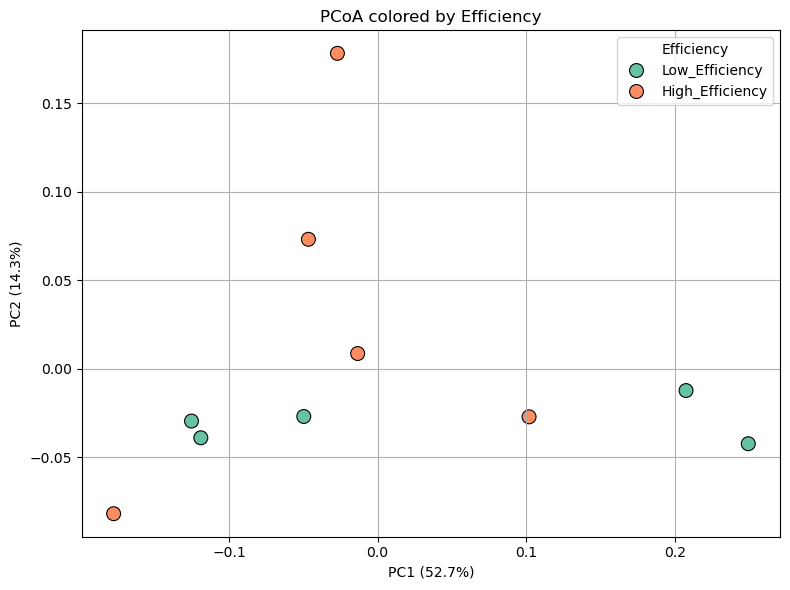

In [ ]:


make_pca(abundance_df=df, metadata_df=m_df, hue_col="Group")
make_pca(abundance_df=df, metadata_df=m_df[m_df['Group'].isin(['PR_R', 'NS_R'])], hue_col="Group", interecept_dfs=True)
make_pca(abundance_df=df, metadata_df=m_df[m_df['Group'] == 'PR_R' ], hue_col="Efficiency", interecept_dfs=True)
make_pca(abundance_df=df, metadata_df=m_df[m_df['Group'] == 'NS_R' ], hue_col="Efficiency", interecept_dfs=True)

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.diversity.alpha import shannon, simpson, chao1

def plot_sample_richness(
    abundance_df: pd.DataFrame,
    metadata_df: pd.DataFrame,
    hue_col: str,
    interecept_dfs: bool = False,
    metric: str = "observed"
):
    """
    Plot richness or alpha diversity per sample group.

    Parameters:
    - abundance_df: DataFrame with samples as rows and taxa/features as columns.
    - metadata_df: DataFrame with samples as index and metadata columns.
    - hue_col: Column in metadata_df to group samples.
    - interecept_dfs: If True, intersect the index of both dataframes.
    - metric: One of {"observed", "shannon", "simpson", "chao1"}.
    """
    if interecept_dfs:
        shared_index = abundance_df.index.intersection(metadata_df.index)
        abundance_df = abundance_df.loc[shared_index]
        metadata_df = metadata_df.loc[shared_index]

    # Select metric
    if metric == "observed":
        richness = (abundance_df > 0).sum(axis=1)
    elif metric == "shannon":
        richness = abundance_df.apply(shannon, axis=1)
    elif metric == "simpson":
        richness = abundance_df.apply(simpson, axis=1)
    elif metric == "chao1":
        richness = abundance_df.apply(chao1, axis=1)
    else:
        raise ValueError(f"Unsupported metric '{metric}'. Choose from: observed, shannon, simpson, chao1.")

    richness.name = metric

    # Merge with metadata
    richness_df = richness.to_frame().join(metadata_df)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=richness_df, x=hue_col, y=metric, palette="Set2")
    sns.stripplot(data=richness_df, x=hue_col, y=metric, color="black", alpha=0.5, jitter=True)
    plt.title(f"{metric.capitalize()} by {hue_col}")
    plt.ylabel(f"{metric.capitalize()} index")
    plt.xlabel(hue_col)
    plt.tight_layout()
    plt.ylim(bottom=0)
    plt.grid(True, axis="y")
    plt.show()


In [14]:
#df.index.intersection()
pr_r_index = m_df['Group'].isin(['PR_R'])
ns_r_index = m_df['Group'].isin(['NS_R'])

In [16]:
pr_r_df

""
PR26NR056MG
PR27NT046MG
PR27NT045MG
PR26NR007MG
PR27NT015MG
PR27NT070MG
PR26NR042MG
PR26NR044MG
PR26NR026MG
PR27NT067MG


In [17]:
df

,12844,51-20,AC2028,Absicoccus,Acetatifactor,Acetitomaculum,Acidaminococcus,Agathobacter,Alloprevotella,Anaerobutyricum,...,UMGS1696,UMGS1820,UMGS1865,UMGS874,UMGS995,V9D3004,Weimerbacter,XBB2008,Zag1,Zag111
PR26NR056MG,382.0,708.0,4447.0,309.0,3047.0,250.0,319.0,3181.0,695.0,13431.0,...,10418.0,1408.0,1505.0,132.0,943.0,300.0,1071.0,682.0,5413.0,4469.0
PR27NT046MG,957.0,564.0,4466.0,434.0,1226.0,176.0,220.0,4767.0,1436.0,4510.0,...,10720.0,2135.0,359.0,84.0,704.0,247.0,1369.0,320.0,852.0,958.0
PR27NT045MG,233.0,1527.0,1178.0,207.0,727.0,187.0,921.0,114714.0,1321.0,3549.0,...,4973.0,1242.0,200.0,54.0,490.0,263.0,9530.0,168.0,796.0,1310.0
PR26NR007MG,427.0,573.0,4064.0,294.0,8490.0,328.0,438.0,4287.0,2688.0,17813.0,...,16294.0,1294.0,1209.0,183.0,976.0,223.0,2187.0,993.0,1282.0,1968.0
PR27NT015MG,438.0,2428.0,4009.0,248.0,3174.0,271.0,286.0,7610.0,1439.0,6146.0,...,6971.0,1607.0,2357.0,252.0,2254.0,300.0,1500.0,459.0,2350.0,2659.0
PR27NT070MG,430.0,10738.0,2143.0,257.0,1214.0,175.0,320.0,4995.0,1106.0,3367.0,...,2990.0,1468.0,853.0,92.0,1240.0,257.0,1648.0,237.0,1845.0,1682.0
PR26NR042MG,487.0,856.0,4207.0,293.0,2885.0,446.0,439.0,12615.0,2237.0,10987.0,...,9515.0,1215.0,1740.0,128.0,1287.0,269.0,2264.0,735.0,6192.0,3847.0
PR26NR044MG,328.0,600.0,4358.0,304.0,5981.0,612.0,347.0,25684.0,1053.0,12855.0,...,7275.0,920.0,1420.0,193.0,611.0,275.0,6256.0,1441.0,2686.0,4131.0
PR26NR026MG,289.0,1726.0,5658.0,213.0,2694.0,346.0,292.0,4856.0,4896.0,10028.0,...,6631.0,1145.0,1423.0,124.0,1939.0,221.0,1895.0,1135.0,1983.0,4523.0
PR27NT067MG,418.0,1624.0,5031.0,326.0,1490.0,290.0,226.0,31249.0,1005.0,3296.0,...,5722.0,1358.0,823.0,92.0,1043.0,350.0,3066.0,438.0,3491.0,2713.0


In [21]:
pr_r_df

,12844,51-20,AC2028,Absicoccus,Acetatifactor,Acetitomaculum,Acidaminococcus,Agathobacter,Alloprevotella,Anaerobutyricum,...,UMGS1696,UMGS1820,UMGS1865,UMGS874,UMGS995,V9D3004,Weimerbacter,XBB2008,Zag1,Zag111


In [24]:
pr_r_index

LABID
PR26NR067MG     True
PR26NR063MG     True
PR26NR042MG     True
PR26NR026MG     True
PR26NR007MG     True
PR26NR001MG     True
PR26NR069MG     True
PR26NR057MG     True
PR26NR056MG     True
PR26NR044MG     True
PR27NT067MG    False
PR27NT046MG    False
PR27NT012MG    False
PR27NT020MG    False
PR27NT070MG    False
PR27NT015MG    False
PR27NT048MG    False
PR27NT054MG    False
PR27NT045MG    False
PR27NT021MG    False
NS001_MG       False
NS002_MG       False
NS003_MG       False
NS004_MG       False
NS005_MG       False
NS006_MG       False
NS007_MG       False
NS008_MG       False
NS009_MG       False
NS010_MG       False
NaN            False
Name: Group, dtype: bool

In [26]:
common_index1

,12844,51-20,AC2028,Absicoccus,Acetatifactor,Acetitomaculum,Acidaminococcus,Agathobacter,Alloprevotella,Anaerobutyricum,...,UMGS1696,UMGS1820,UMGS1865,UMGS874,UMGS995,V9D3004,Weimerbacter,XBB2008,Zag1,Zag111
PR26NR056MG,382.0,708.0,4447.0,309.0,3047.0,250.0,319.0,3181.0,695.0,13431.0,...,10418.0,1408.0,1505.0,132.0,943.0,300.0,1071.0,682.0,5413.0,4469.0
PR26NR007MG,427.0,573.0,4064.0,294.0,8490.0,328.0,438.0,4287.0,2688.0,17813.0,...,16294.0,1294.0,1209.0,183.0,976.0,223.0,2187.0,993.0,1282.0,1968.0
PR26NR042MG,487.0,856.0,4207.0,293.0,2885.0,446.0,439.0,12615.0,2237.0,10987.0,...,9515.0,1215.0,1740.0,128.0,1287.0,269.0,2264.0,735.0,6192.0,3847.0
PR26NR044MG,328.0,600.0,4358.0,304.0,5981.0,612.0,347.0,25684.0,1053.0,12855.0,...,7275.0,920.0,1420.0,193.0,611.0,275.0,6256.0,1441.0,2686.0,4131.0
PR26NR026MG,289.0,1726.0,5658.0,213.0,2694.0,346.0,292.0,4856.0,4896.0,10028.0,...,6631.0,1145.0,1423.0,124.0,1939.0,221.0,1895.0,1135.0,1983.0,4523.0
PR26NR069MG,379.0,290.0,4937.0,286.0,4284.0,348.0,332.0,4819.0,1155.0,26690.0,...,16684.0,1323.0,1215.0,141.0,737.0,342.0,2768.0,1913.0,2757.0,5077.0
PR26NR057MG,215.0,185.0,2954.0,348.0,2405.0,242.0,308.0,29798.0,1996.0,13126.0,...,4446.0,730.0,848.0,125.0,2393.0,159.0,2252.0,631.0,1932.0,1826.0
PR26NR001MG,432.0,251.0,5774.0,274.0,3991.0,401.0,383.0,18191.0,1179.0,13857.0,...,12003.0,1361.0,1431.0,170.0,1793.0,300.0,3159.0,903.0,2013.0,4074.0
PR26NR063MG,306.0,817.0,4546.0,244.0,4098.0,207.0,229.0,3929.0,1191.0,6626.0,...,6754.0,1164.0,1628.0,114.0,877.0,312.0,1286.0,537.0,1865.0,3782.0
PR26NR067MG,236.0,230.0,2719.0,284.0,1580.0,379.0,264.0,111520.0,1692.0,6719.0,...,2582.0,595.0,200.0,128.0,358.0,236.0,9534.0,449.0,2014.0,549.0


In [31]:
ns_r_df

,12844,51-20,AC2028,Absicoccus,Acetatifactor,Acetitomaculum,Acidaminococcus,Agathobacter,Alloprevotella,Anaerobutyricum,...,UMGS1696,UMGS1820,UMGS1865,UMGS874,UMGS995,V9D3004,Weimerbacter,XBB2008,Zag1,Zag111
NS006_MG,434.0,392.0,3112.0,224.0,2659.0,315.0,176.0,3359.0,537.0,5351.0,...,6248.0,1406.0,597.0,107.0,1195.0,384.0,1429.0,622.0,1689.0,2355.0
NS004_MG,467.0,1018.0,4400.0,233.0,2261.0,221.0,277.0,2967.0,668.0,6464.0,...,6144.0,1486.0,2303.0,107.0,1010.0,314.0,1425.0,2104.0,5829.0,8116.0
NS001_MG,352.0,408.0,3210.0,314.0,1794.0,329.0,282.0,8924.0,1015.0,7691.0,...,5014.0,1197.0,440.0,127.0,689.0,316.0,16597.0,1107.0,6270.0,3057.0
NS003_MG,383.0,604.0,2385.0,223.0,2937.0,223.0,196.0,3812.0,883.0,3592.0,...,3867.0,1450.0,468.0,73.0,980.0,336.0,1760.0,477.0,5985.0,6372.0
NS008_MG,349.0,477.0,3309.0,262.0,2621.0,301.0,209.0,6420.0,1459.0,6764.0,...,2548.0,1126.0,1928.0,70.0,1478.0,244.0,4164.0,610.0,3468.0,5282.0
NS007_MG,210.0,1405.0,2874.0,273.0,1427.0,1100.0,199.0,100586.0,1638.0,5383.0,...,1781.0,864.0,655.0,71.0,1613.0,261.0,7731.0,387.0,1036.0,1646.0
NS002_MG,344.0,273.0,2175.0,274.0,1022.0,242.0,185.0,4248.0,1545.0,5117.0,...,3674.0,1258.0,500.0,102.0,866.0,279.0,2058.0,402.0,2182.0,2115.0
NS009_MG,558.0,979.0,7897.0,210.0,6013.0,453.0,239.0,5409.0,1221.0,6462.0,...,5842.0,1557.0,2924.0,120.0,1127.0,380.0,1761.0,1156.0,2613.0,3223.0
NS010_MG,548.0,19695.0,5275.0,264.0,4310.0,336.0,244.0,4182.0,634.0,5880.0,...,4163.0,1440.0,1490.0,129.0,2165.0,355.0,2171.0,1006.0,2073.0,2669.0
NS005_MG,387.0,639.0,2983.0,255.0,1301.0,167.0,187.0,2072.0,1327.0,2086.0,...,2164.0,1399.0,684.0,89.0,1147.0,296.0,1201.0,274.0,2935.0,3854.0


In [36]:
abundance1_means

PR26NR056MG    14061.944348
PR26NR007MG    14312.786087
PR26NR042MG    15864.968696
PR26NR044MG    20475.231304
PR26NR026MG    17623.325217
PR26NR069MG    15316.220870
PR26NR057MG    22499.970435
PR26NR001MG    16725.380870
PR26NR063MG    16290.626087
PR26NR067MG    24538.740870
dtype: float64

In [48]:
abundance2_means

12844             403.2
51-20            2589.0
AC2028           3762.0
Absicoccus        253.2
Acetatifactor    2634.5
                  ...  
V9D3004           316.5
Weimerbacter     4029.7
XBB2008           814.5
Zag1             3408.0
Zag111           3868.9
Length: 575, dtype: float64

In [47]:
from scipy.stats import spearmanr


pr_r_serie = m_df['Group'].isin(['PR_E'])
ns_r_serie = m_df['Group'].isin(['NS_R'])

common_index1 = df.index.intersection(m_df[pr_r_serie].index)
common_index2 = df.index.intersection(m_df[ns_r_serie].index)

pr_r_df = df.loc[common_index1, :]
ns_r_df = df.loc[common_index2, :]

abundance1_means = pr_r_df.mean(axis=0)
abundance2_means = ns_r_df.mean(axis=0)

abundance2_means = abundance2_means[abundance1_means.index]

corr, pval = spearmanr(abundance1_means, abundance2_means)
print(f"Spearman correlation: {corr:.8f}, p-value: {pval}")


Spearman correlation: 0.89961130, p-value: 2.446746278830805e-208


/tmp/ipykernel_1485727/2829966200.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=richness_df, x=hue_col, y=metric, palette="Set2")


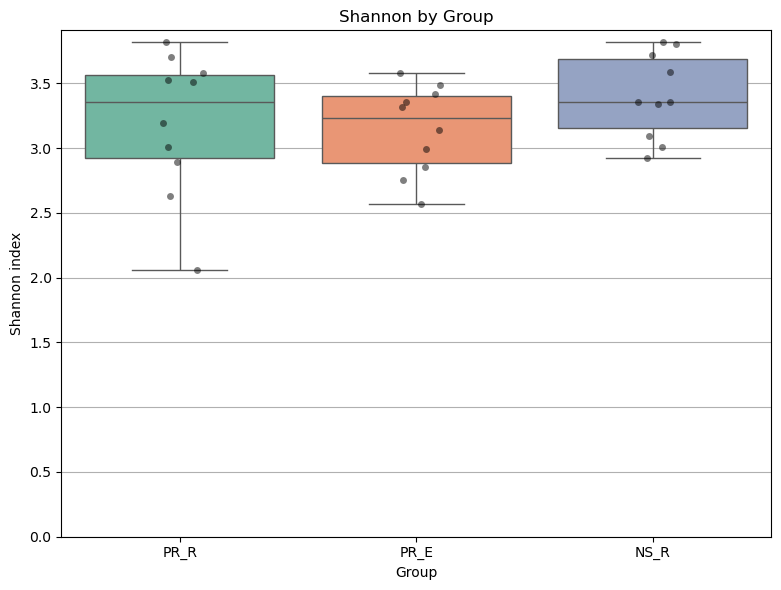

In [25]:
#plot_sample_richness(abundance_df=df, metadata_df=m_df, hue_col="Group", interecept_dfs=True)
plot_sample_richness(abundance_df=df, metadata_df=m_df, hue_col="Group", interecept_dfs=True, metric='shannon')
#plot_sample_richness(abundance_df=df, metadata_df=m_df, hue_col="Group", interecept_dfs=True, metric='chao1')
#plot_sample_richness(abundance_df=df, metadata_df=m_df[m_df['Group'].isin(['PR_R', 'NS_R'])], hue_col="Group", interecept_dfs=True,metric='shannon')

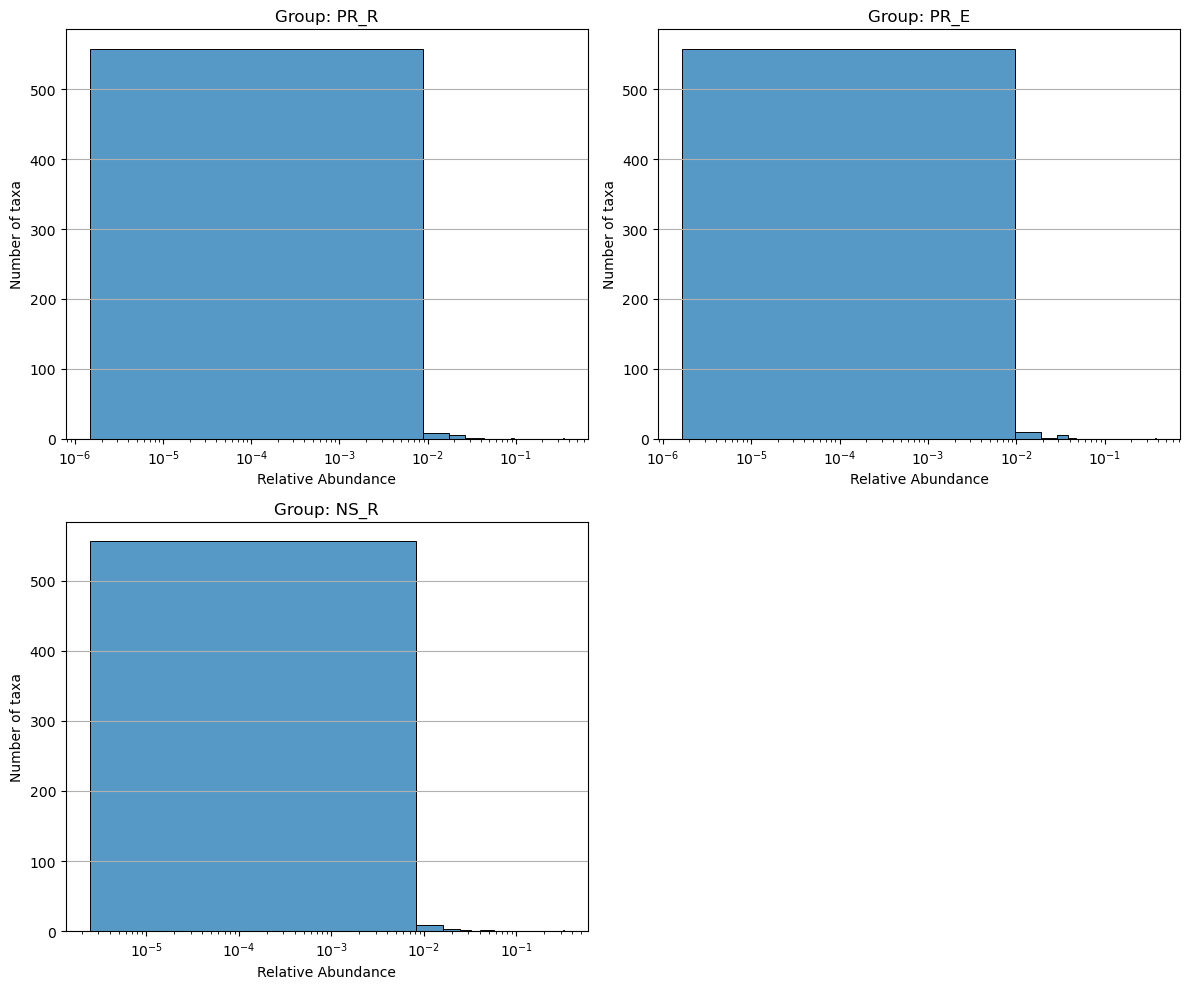

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_taxa_abundance_distribution(
    abundance_df: pd.DataFrame,
    metadata_df: pd.DataFrame,
    group_col: str,
    relative: bool = False,
    average_across_samples: bool = False,
    log_scale: bool = True,
    bins: int = 50
):
    """
    Plot the distribution of taxa abundances for each group defined in metadata.

    Parameters:
    - abundance_df: DataFrame with samples as rows and taxa as columns.
    - metadata_df: DataFrame with sample metadata (index must match abundance_df).
    - group_col: Column name in metadata_df to group samples.
    - relative: Whether to use relative abundances (normalize rows).
    - average_across_samples: Whether to average abundance across group samples before plotting.
    - log_scale: Whether to use log scale for the x-axis.
    - bins: Number of bins for the histogram.
    """
    # Intersect sample indexes
    shared_index = abundance_df.index.intersection(metadata_df.index)
    abundance_df = abundance_df.loc[shared_index]
    metadata_df = metadata_df.loc[shared_index]

    if relative:
        abundance_df = abundance_df.div(abundance_df.sum(axis=1), axis=0).fillna(0)

    # Group samples by the metadata column
    grouped = metadata_df[group_col].unique()
    n_groups = len(grouped)

    # Determine layout for subplots
    n_cols = 2
    n_rows = (n_groups + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, group in enumerate(grouped):
        ax = axes[i]
        samples_in_group = metadata_df[metadata_df[group_col] == group].index
        group_abundance = abundance_df.loc[samples_in_group]

        # Calculate taxa abundance vector
        if average_across_samples:
            taxa_abundances = group_abundance.mean(axis=0)
        else:
            taxa_abundances = group_abundance.sum(axis=0)

        taxa_abundances = taxa_abundances[taxa_abundances > 0]

        sns.histplot(taxa_abundances, bins=bins, edgecolor="black", ax=ax)
        ax.set_title(f"{group_col}: {group}")
        ax.set_xlabel("Relative Abundance" if relative else "Raw Abundance")
        ax.set_ylabel("Number of taxa")

        if log_scale:
            ax.set_xscale("log")

        ax.grid(True, which="both", axis="y")

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_grouped_taxa_abundance_distribution(
    df,
    m_df,
    group_col="Group",
    relative=True,
    average_across_samples=True,
    log_scale=True,
    bins=40
)


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_taxa_abundance(
    abundance_df: pd.DataFrame,
    metadata_df: pd.DataFrame = None,
    group_col: str = None,
    relative: bool = True,
    aggregate: bool = True,
    plot_type: str = "hist",
    top_n: int = 20
):
    """
    Plot abundance distribution of taxa.

    Parameters:
    - abundance_df: DataFrame with samples as rows and taxa as columns.
    - metadata_df: Optional metadata DataFrame with group info.
    - group_col: Column name in metadata_df to group samples.
    - relative: If True, use relative abundance.
    - aggregate: If True, aggregate per group (or globally if group_col is None).
    - plot_type: "hist" (barplot) or "line" (line plot).
    - top_n: Number of top-abundant taxa to display.
    """
    data = abundance_df.copy()

    if relative:
        data = data.div(data.sum(axis=1), axis=0)

    # Reduce to top N abundant taxa
    mean_abundance = data.mean().sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index
    data = data[top_taxa]

    if group_col and metadata_df is not None:
        data = data.join(metadata_df[group_col])
        grouped = data.groupby(group_col)
        data = grouped.mean()

    elif aggregate:
        data = pd.DataFrame(data.mean()).T

    # Plot
    plt.figure(figsize=(10, 6))

    if plot_type == "hist":
        data.T.plot(kind="bar", stacked=True)
        plt.xticks(rotation=90)
    elif plot_type == "line":
        data.T.plot(kind="line", marker='o')
        plt.xticks(rotation=90)
    else:
        raise ValueError("plot_type must be either 'hist' or 'line'")

    ylabel = "Relative Abundance" if relative else "Raw Abundance"
    plt.ylabel(ylabel)
    plt.title("Taxa Abundance" + (f" by {group_col}" if group_col else ""))
    plt.xlabel("Taxa")
    plt.tight_layout()
    plt.legend(title=group_col if group_col else "Group")
    plt.grid(True)
    plt.show()


<Figure size 1000x600 with 0 Axes>

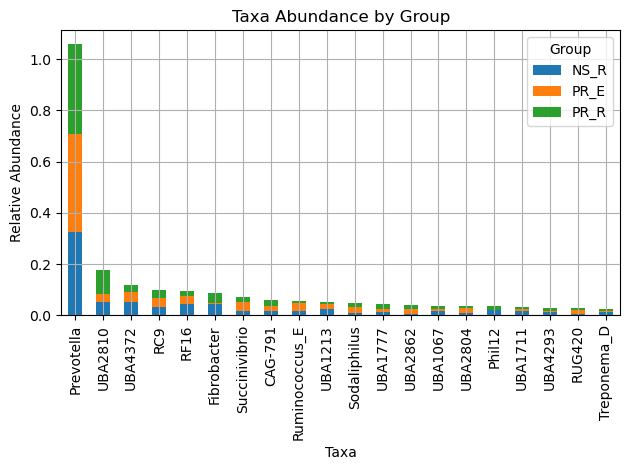

In [30]:
plot_taxa_abundance(abundance_df=df, metadata_df=m_df, group_col="Group", aggregate=False)

/home/jpereira/miniconda3/envs/cluster-vis-env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.030154979514294248 whereas the largest positive one is 0.8151650126955137.
  warn(
/tmp/ipykernel_467561/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

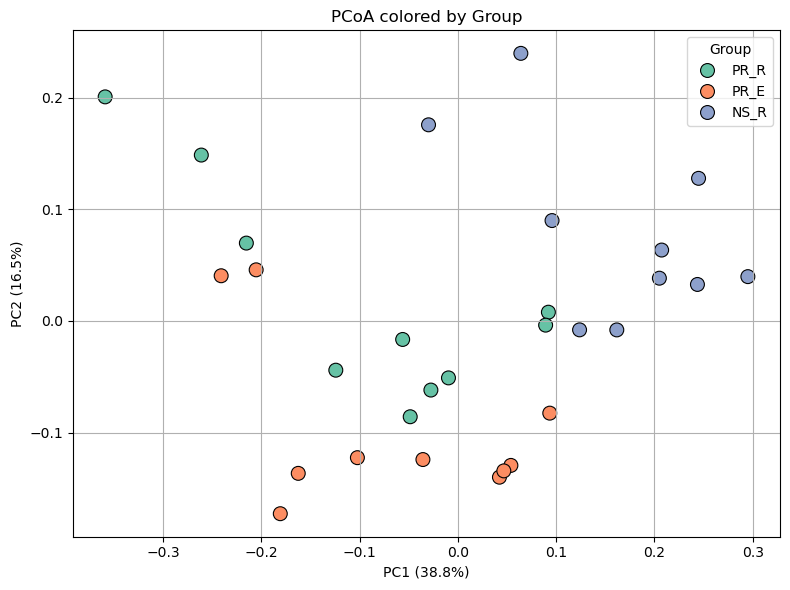

/home/jpereira/miniconda3/envs/cluster-vis-env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.018683651775810103 whereas the largest positive one is 0.6319038905508264.
  warn(
/tmp/ipykernel_467561/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

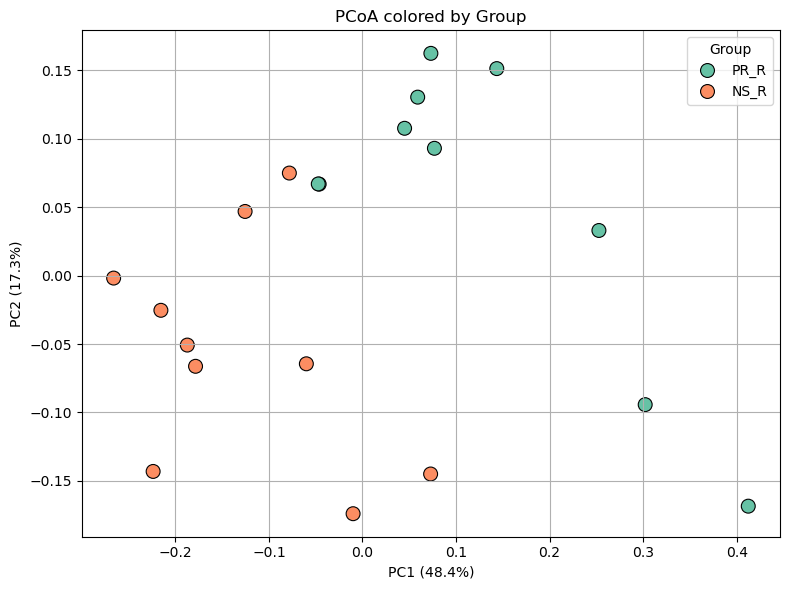

/tmp/ipykernel_467561/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


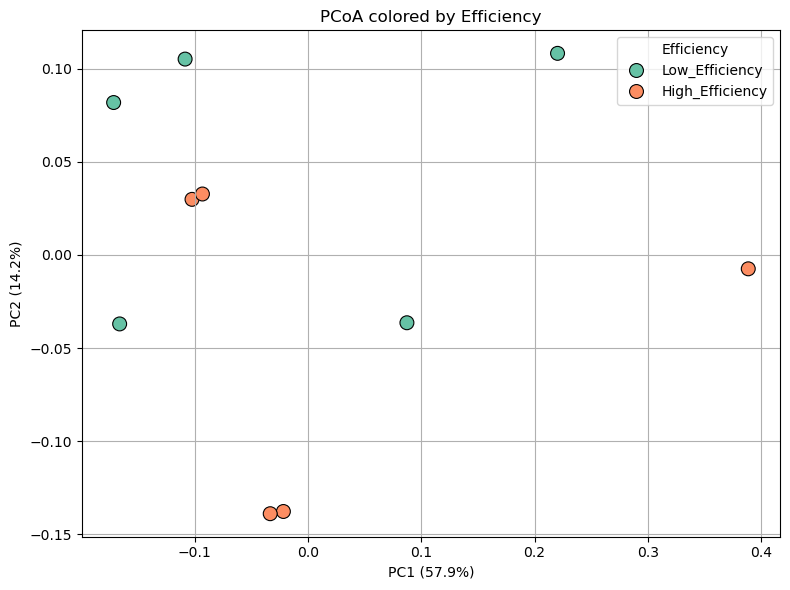

/tmp/ipykernel_467561/2899752072.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/2899752072.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


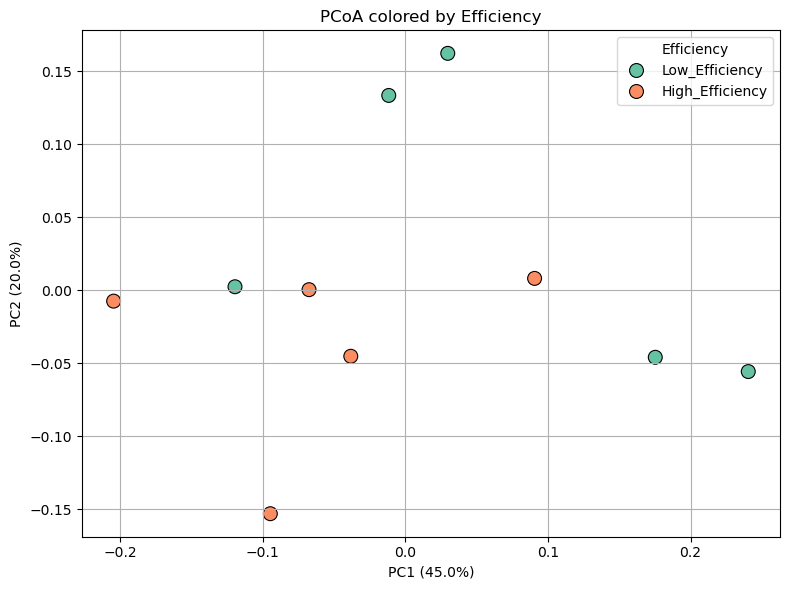

In [83]:
# Sample filter
mask = df.index.str.startswith("NS")

df2 = df.copy()

# Apply operation only to those rows (e.g., multiply by 2)
df2.loc[mask] = (df.loc[mask] / 2.5).round().astype(int)

make_pca(abundance_df=df2, metadata_df=m_df, hue_col="Group")
make_pca(abundance_df=df2, metadata_df=m_df[m_df['Group'].isin(['PR_R', 'NS_R'])], hue_col="Group", interecept_dfs=True)
make_pca(abundance_df=df2, metadata_df=m_df[m_df['Group'] == 'PR_R' ], hue_col="Efficiency", interecept_dfs=True)
make_pca(abundance_df=df2, metadata_df=m_df[m_df['Group'] == 'NS_R' ], hue_col="Efficiency", interecept_dfs=True)

/tmp/ipykernel_467561/425626281.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/425626281.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


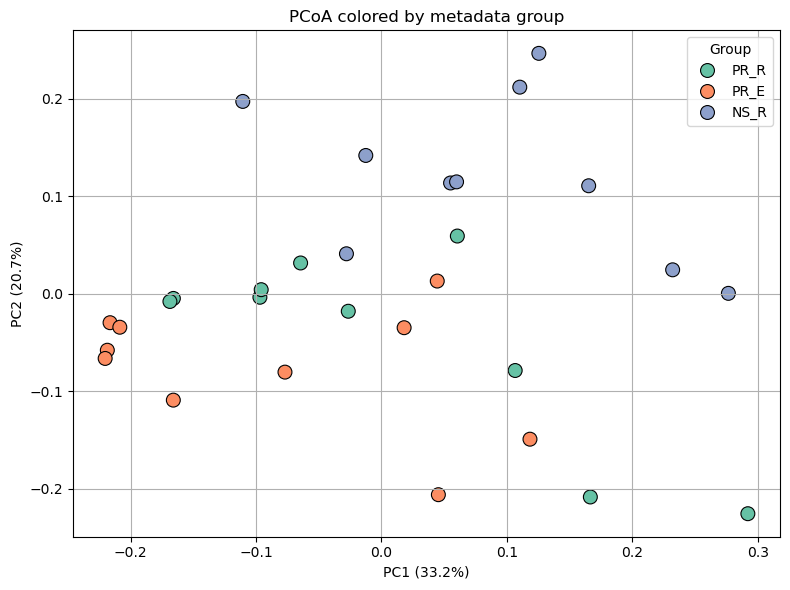

/tmp/ipykernel_467561/425626281.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/425626281.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


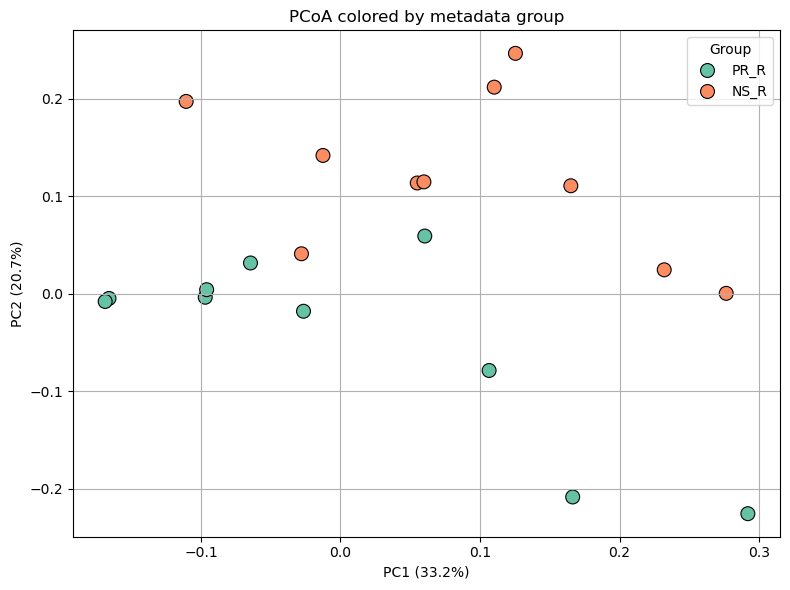

/tmp/ipykernel_467561/425626281.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/425626281.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


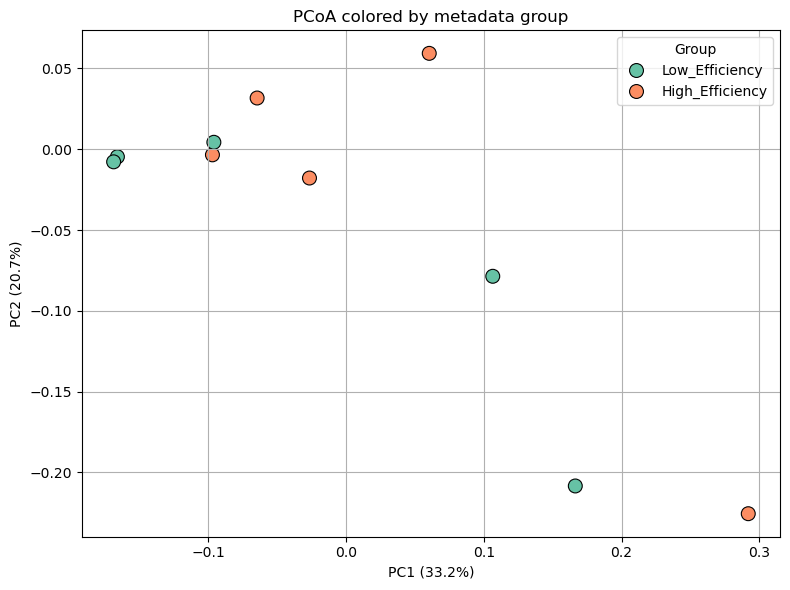

/tmp/ipykernel_467561/425626281.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/425626281.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


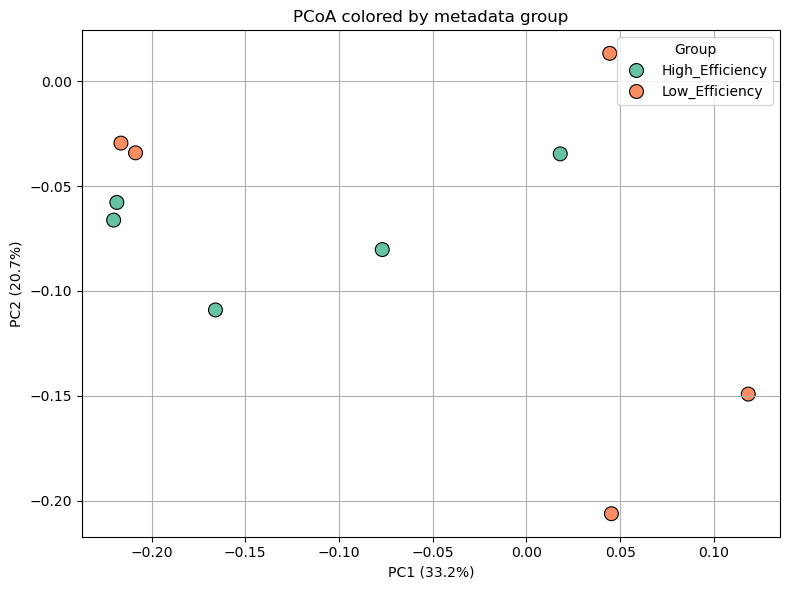

/tmp/ipykernel_467561/425626281.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_467561/425626281.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


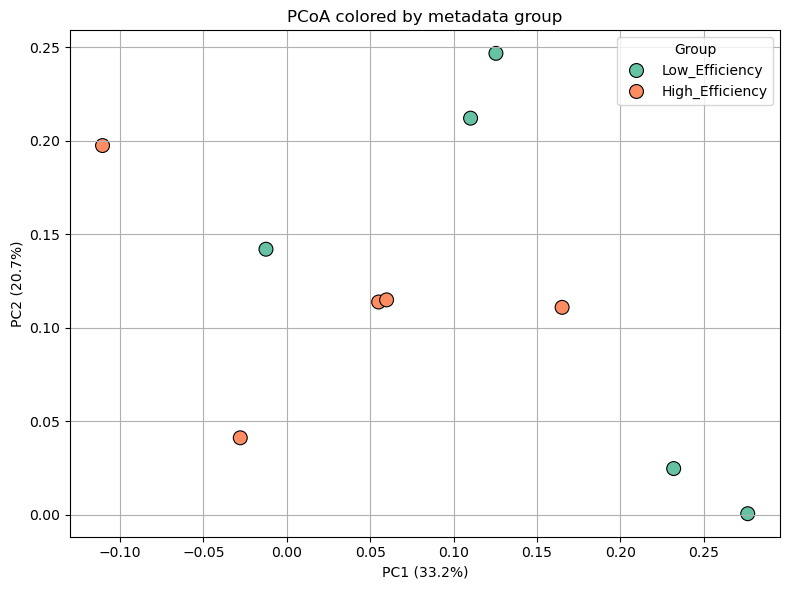

In [59]:
def plot_pca(df: pd.DataFrame, hue_col: str):
    # Plot with seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="PC1",
        y="PC2",
        hue=hue_col,  # replace with your metadata column name
        palette="Set2",
        s=100,
        edgecolor="black"
    )
    plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")
    plt.title("PCoA colored by metadata group")
    plt.grid(True)
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()
    return

df_plot = coords_with_meta


plot_pca(coords_with_meta, 'Group')
plot_pca(df_plot[df_plot['Group'].isin(["PR_R", "NS_R"])], 'Group')
plot_pca(df_plot[df_plot['Group'] == "PR_R"], 'Efficiency')
plot_pca(df_plot[df_plot['Group'] == "PR_E"], 'Efficiency')
plot_pca(df_plot[df_plot['Group'] == "NS_R"], 'Efficiency')


/tmp/ipykernel_1454624/1411571884.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([shallow_subsampled_richness, deep_subsampled_richness],


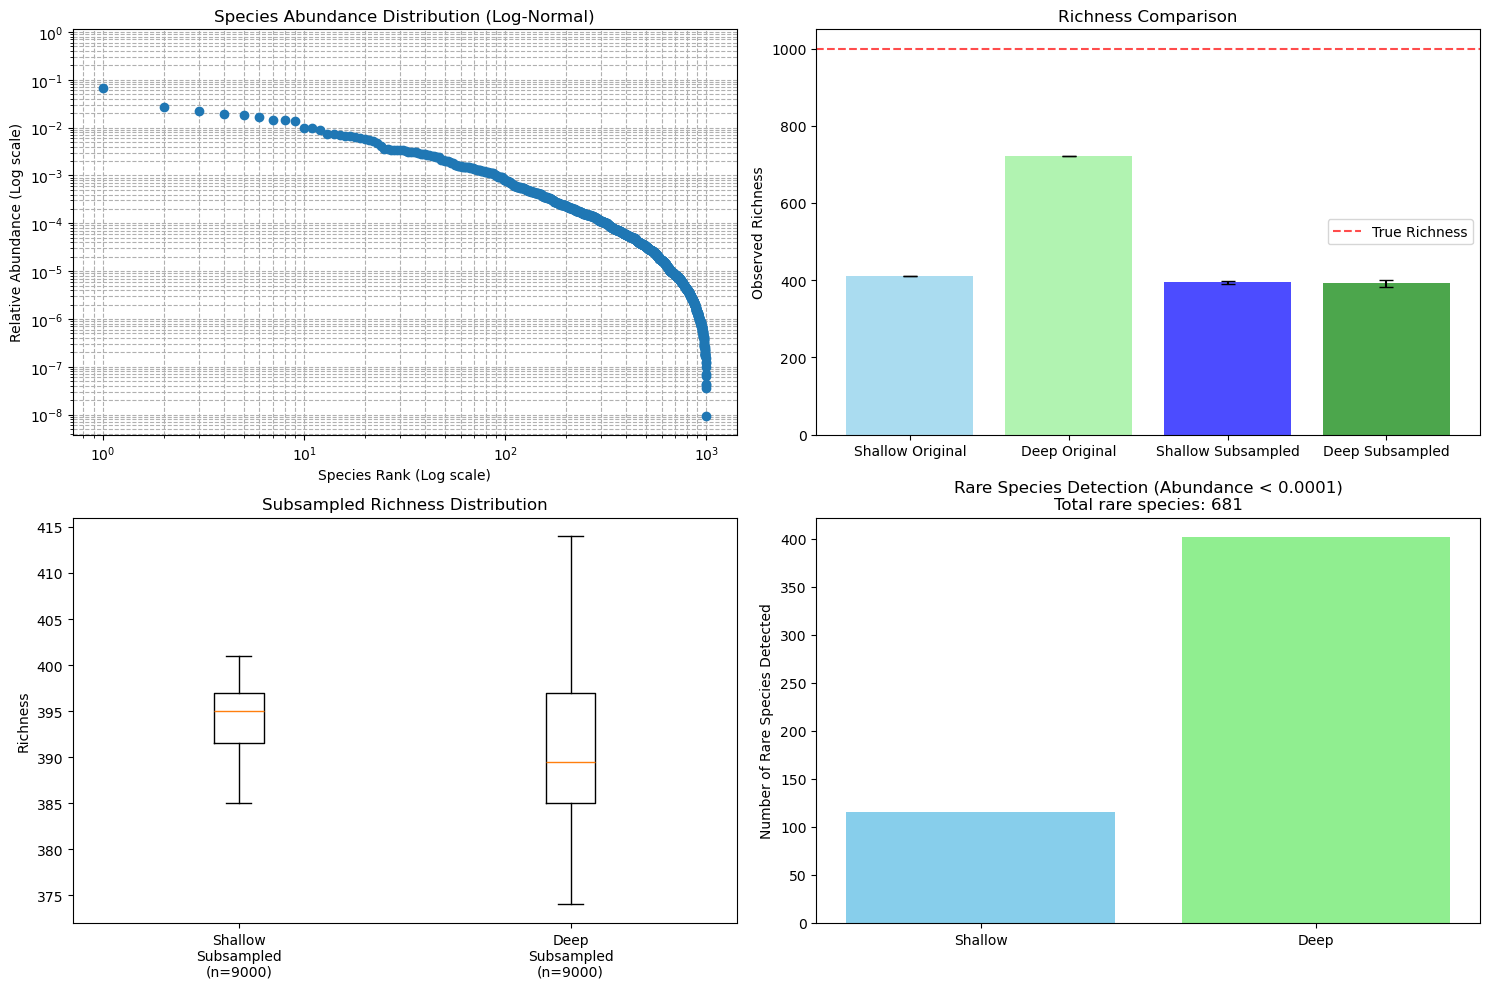

True richness: 1000
Original shallow richness: 410 (Depth: 10000)
Original deep richness: 721 (Depth: 100000)
Subsampled shallow richness: 394.5 ± 4.1
Subsampled deep richness: 391.7 ± 8.6
Probability of detecting a rare species:
  Shallow: 0.1703
  Deep: 0.5903


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

# =====================
# PARAMETER SETUP
# =====================
S = 1000                      # True species richness
mu, sigma = -3, 2.5           # Parameters for log-normal abundance distribution
shallow_depth = 10000          # Sequencing depth for shallow sample
deep_depth = 100000            # Sequencing depth for deep sample
subsample_depth = 9000         # Depth for subsampling
n_simulations = 50            # Number of subsampling iterations

# =====================
# SPECIES ABUNDANCE MODEL
# =====================
# Generate log-normally distributed relative abundances
log_abundances = np.random.lognormal(mean=mu, sigma=sigma, size=S)
relative_abundances = log_abundances / log_abundances.sum()
true_richness = S

# Sort abundances for visualization
sorted_abundances = np.sort(relative_abundances)[::-1]

# =====================
# SEQUENCING SIMULATION
# =====================
def simulate_sequencing(abundances, depth):
    """Simulate multinomial sequencing of a community"""
    counts = np.random.multinomial(depth, abundances)
    return counts

# Generate original samples
shallow_sample = simulate_sequencing(relative_abundances, shallow_depth)
deep_sample = simulate_sequencing(relative_abundances, deep_depth)

# Calculate original richness
shallow_richness = np.sum(shallow_sample > 0)
deep_richness = np.sum(deep_sample > 0)

# =====================
# SUBSAMPLING FUNCTION
# =====================
def subsample(counts, subsample_depth):
    """Subsample reads without replacement"""
    total_reads = counts.sum()
    indices = np.arange(len(counts))
    # Create expanded list of all reads
    all_reads = np.repeat(indices, counts)
    # Subsample
    subsampled = np.random.choice(all_reads, size=subsample_depth, replace=False)
    unique, counts_subsampled = np.unique(subsampled, return_counts=True)
    subsampled_counts = np.zeros_like(counts)
    subsampled_counts[unique] = counts_subsampled
    return subsampled_counts

# =====================
# SUBSAMPLING SIMULATION
# =====================
shallow_subsampled_richness = []
deep_subsampled_richness = []

for _ in range(n_simulations):
    # Subsample both datasets
    shallow_subsampled = subsample(shallow_sample, subsample_depth)
    deep_subsampled = subsample(deep_sample, subsample_depth)
    
    # Record richness
    shallow_subsampled_richness.append(np.sum(shallow_subsampled > 0))
    deep_subsampled_richness.append(np.sum(deep_subsampled > 0))

# =====================
# VISUALIZATION
# =====================
plt.figure(figsize=(15, 10))

# Plot 1: Species abundance distribution
plt.subplot(2, 2, 1)
plt.loglog(sorted_abundances, 'o')
plt.title("Species Abundance Distribution (Log-Normal)")
plt.xlabel("Species Rank (Log scale)")
plt.ylabel("Relative Abundance (Log scale)")
plt.grid(True, which="both", ls="--")

# Plot 2: Original vs subsampled richness
plt.subplot(2, 2, 2)
positions = [1, 2, 3, 4]
labels = ['Shallow Original', 'Deep Original', 'Shallow Subsampled', 'Deep Subsampled']
values = [shallow_richness, deep_richness, 
          np.mean(shallow_subsampled_richness), 
          np.mean(deep_subsampled_richness)]
errors = [0, 0, 
          np.std(shallow_subsampled_richness), 
          np.std(deep_subsampled_richness)]

plt.bar(positions, values, yerr=errors, 
        color=['skyblue', 'lightgreen', 'blue', 'green'],
        alpha=0.7, capsize=5)
plt.xticks(positions, labels)
plt.ylabel("Observed Richness")
plt.title("Richness Comparison")
plt.axhline(y=true_richness, color='r', linestyle='--', alpha=0.7)
plt.legend(['True Richness'])

# Plot 3: Boxplot of subsampled richness
plt.subplot(2, 2, 3)
plt.boxplot([shallow_subsampled_richness, deep_subsampled_richness],
            labels=[f'Shallow\nSubsampled\n(n={subsample_depth})', 
                    f'Deep\nSubsampled\n(n={subsample_depth})'])
plt.ylabel("Richness")
plt.title("Subsampled Richness Distribution")

# Plot 4: Rare species detection
detected_in_shallow = shallow_sample > 0
detected_in_deep = deep_sample > 0
rare_species = np.where(relative_abundances < 1e-4)[0]

rare_detection_shallow = np.sum(shallow_sample[rare_species] > 0)
rare_detection_deep = np.sum(deep_sample[rare_species] > 0)

plt.subplot(2, 2, 4)
plt.bar(['Shallow', 'Deep'], [rare_detection_shallow, rare_detection_deep],
        color=['skyblue', 'lightgreen'])
plt.ylabel("Number of Rare Species Detected")
plt.title(f"Rare Species Detection (Abundance < 0.0001)\nTotal rare species: {len(rare_species)}")

plt.tight_layout()
plt.show()

# =====================
# STATISTICAL SUMMARY
# =====================
print(f"True richness: {true_richness}")
print(f"Original shallow richness: {shallow_richness} (Depth: {shallow_depth})")
print(f"Original deep richness: {deep_richness} (Depth: {deep_depth})")
print(f"Subsampled shallow richness: {np.mean(shallow_subsampled_richness):.1f} ± {np.std(shallow_subsampled_richness):.1f}")
print(f"Subsampled deep richness: {np.mean(deep_subsampled_richness):.1f} ± {np.std(deep_subsampled_richness):.1f}")
print(f"Probability of detecting a rare species:")
print(f"  Shallow: {rare_detection_shallow/len(rare_species):.4f}")
print(f"  Deep: {rare_detection_deep/len(rare_species):.4f}")